In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os


In [2]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



In [10]:
# Define the data directory
data_dir = '/home/anon/MajorProject/Data/Dataset_alpha_split'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
#image_datasets

In [11]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 1223, 'test': 277}


['Brightness_Decrease',
 'Brightness_Increase',
 'Chrome_Open',
 'Cursor_Movement',
 'Double_Click',
 'Initiation',
 'Left_Click',
 'Neutral',
 'Nothing',
 'Right_Click',
 'Screenshot',
 'Scroll',
 'Shutdown',
 'Volume_Decrease',
 'Volume_Increase']

In [5]:
# Load the pre-trained ResNet-18 model
# model = models.resnet18(pretrained=True)
from torchvision.models import resnet50, ResNet50_Weights


# Strings are also supported
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

# Freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Use all parameters


# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


NameError: name 'nn' is not defined

In [13]:
# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")


train Loss: 4.7426 Acc: 0.1979
test Loss: 3.1803 Acc: 0.5307
train Loss: 2.4400 Acc: 0.5282
test Loss: 1.7923 Acc: 0.8231
train Loss: 1.8489 Acc: 0.6582
test Loss: 1.2619 Acc: 0.9134
train Loss: 1.5601 Acc: 0.7269
test Loss: 0.8967 Acc: 0.9711
train Loss: 1.3757 Acc: 0.7637
test Loss: 0.6445 Acc: 0.9819
train Loss: 1.2495 Acc: 0.7784
test Loss: 0.5029 Acc: 0.9892
train Loss: 1.1216 Acc: 0.8013
test Loss: 0.5100 Acc: 0.9928
train Loss: 1.0308 Acc: 0.8242
test Loss: 0.3411 Acc: 0.9928
train Loss: 0.9907 Acc: 0.8275
test Loss: 0.3677 Acc: 0.9892
train Loss: 0.9277 Acc: 0.8275
test Loss: 0.2904 Acc: 0.9964
train Loss: 0.8949 Acc: 0.8381
test Loss: 0.2213 Acc: 0.9928
train Loss: 0.8419 Acc: 0.8463
test Loss: 0.2330 Acc: 0.9928
train Loss: 0.7954 Acc: 0.8569
test Loss: 0.2006 Acc: 0.9928
train Loss: 0.7912 Acc: 0.8553
test Loss: 0.1835 Acc: 0.9928
train Loss: 0.7237 Acc: 0.8733
test Loss: 0.1706 Acc: 0.9928
Training complete!


In [14]:

# Save the model
torch.save(model.state_dict(), '/home/anon/MajorProject/Non_Git/Models/dataset_alpha_resnet50.pth')


# Classification on Unseen Image

To use the saved model to classify unseen images, you need to load the model and then apply it to the new images for inference. 

In [7]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load the saved model
model = resnet50(weights=weights)

model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('/home/anon/MajorProject/Non_Git/Models/dataset_alpha_resnet50.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet50(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]




/home/anon/miniconda3/envs/major_pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/anon/miniconda3/envs/major_pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare your new image for classification. You should use the same data transformations you used during training. Here's an example of how to prepare an image for inference:

In [11]:
# Load and preprocess the unseen image
image_path = '/home/anon/MajorProject/Non_Git/classmates_test_images/fista.jpg'  # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension


Perform inference using the model:

In [12]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
# class_names = ['A','B','Blank','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
class_names = ['Brightness_Decrease',
 'Brightness_Increase',
 'Chrome_Open',
 'Cursor_Movement',
 'Double_Click',
 'Initiation',
 'Left_Click',
 'Neutral',
 'Nothing',
 'Right_Click',
 'Screenshot',
 'Scroll',
 'Shutdown',
 'Volume_Decrease',
 'Volume_Increase']
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')


The predicted class is: Double_Click


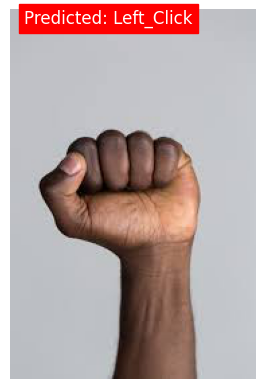

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()